# Customer Churn Prediction

In [67]:
import cloudpickle
import pandas as pd
import matplotlib.pyplot as plt
from btyd import *
from btyd.plotting import (
    plot_frequency_recency_matrix,
    plot_probability_alive_matrix,
    plot_period_transactions,
)
from btyd import GammaGammaFitter
from pandas.core.series import Series
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    roc_auc_score,
    accuracy_score,
)

In [1]:
raw_data = pd.read_parquet("data/wallet_urfu.parquet.gzip")
raw_data.head()

,partner,rep_date,monetary
0,468726,2016-01-02,2.673749e-11
1,134145,2016-01-02,1.069500e-12
2,66774,2016-01-02,2.228576e-12
3,178928,2016-01-02,8.730611e-11
4,679693,2016-01-02,3.492244e-11


In [2]:
rfm_data_train = pd.read_parquet("data/train.parquet.gzip")
rfm_data_test = pd.read_parquet("data/test.parquet.gzip")

count    1.356307e+06
mean     2.966203e+01
std      5.376144e+01
min      0.000000e+00
25%      2.000000e+00
50%      9.000000e+00
75%      3.200000e+01
max      1.137000e+03
Name: frequency, dtype: float64


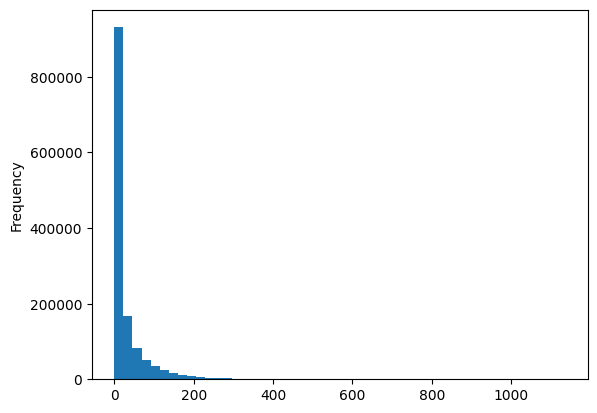

In [4]:
rfm_data_train["frequency"].plot(kind="hist", bins=50)
print(rfm_data_train["frequency"].describe())

In [5]:
one_timers_train = round(
    sum(rfm_data_train["frequency"] == 0) / float(len(rfm_data_train)) * (100), 2
)
print("Процент клиентов one-timer'ов на тренировочной выборке:", one_timers_train, "%")

Процент клиентов one-timer'ов на тренировочной выборке: 12.23 %


count    339077.000000
mean         29.806206
std          53.755775
min           0.000000
25%           2.000000
50%           9.000000
75%          32.000000
max         986.000000
Name: frequency, dtype: float64


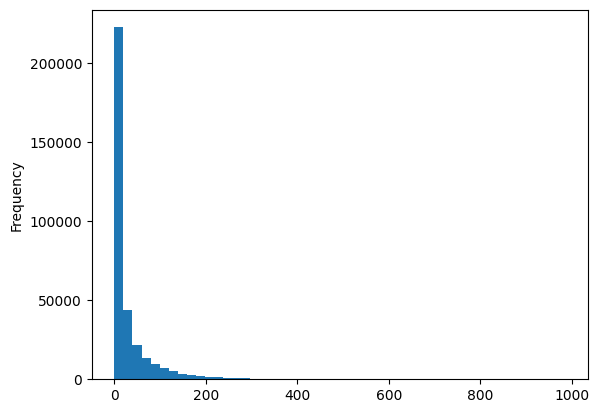

In [6]:
rfm_data_test["frequency"].plot(kind="hist", bins=50)
print(rfm_data_test["frequency"].describe())

In [7]:
one_timers_test = round(
    sum(rfm_data_test["frequency"] == 0) / float(len(rfm_data_test)) * (100), 2
)
print("Процент клиентов one-timer'ов на тестовой выборке:", one_timers_test, "%")

Процент клиентов one-timer'ов на тестовой выборке: 12.13 %


Загрузим модели

In [9]:
# Обычный BetaGeoFitter
bgf = cloudpickle.load(open("./model/new_bgf_on_train.pkl", "rb"))
# ModifiedBetaGeoFitter
mbgf = cloudpickle.load(open("./model/new_mbgf_on_train.pkl", "rb"))

BGF

c:\Codding\Customer-Churn-prediction\.venv\lib\site-packages\btyd\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in scalar power
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

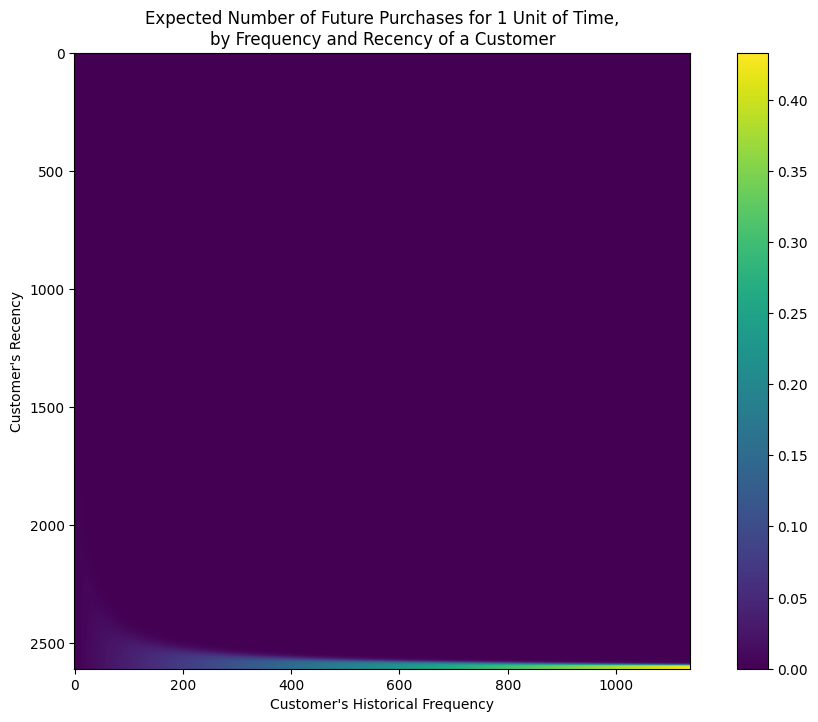

In [68]:
# Визуализация frequency/recency
fig = plt.figure(figsize=(12, 8))
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

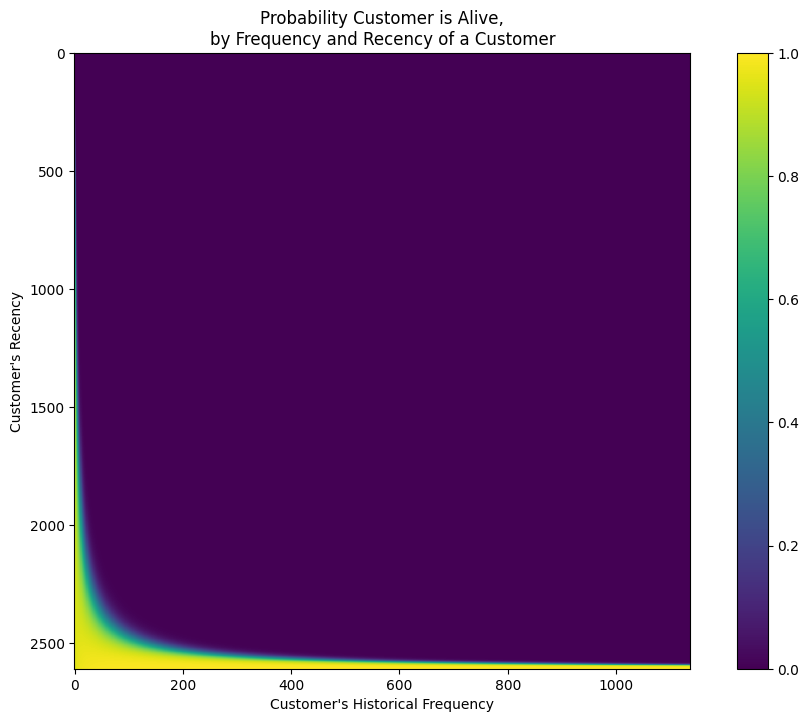

In [69]:
# Визуализация вероятности, что клиент жив:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

MBGF

c:\Codding\Customer-Churn-prediction\.venv\lib\site-packages\btyd\fitters\modified_beta_geo_fitter.py:184: RuntimeWarning: overflow encountered in scalar power
  denominator = 1 + (a / (b + x)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

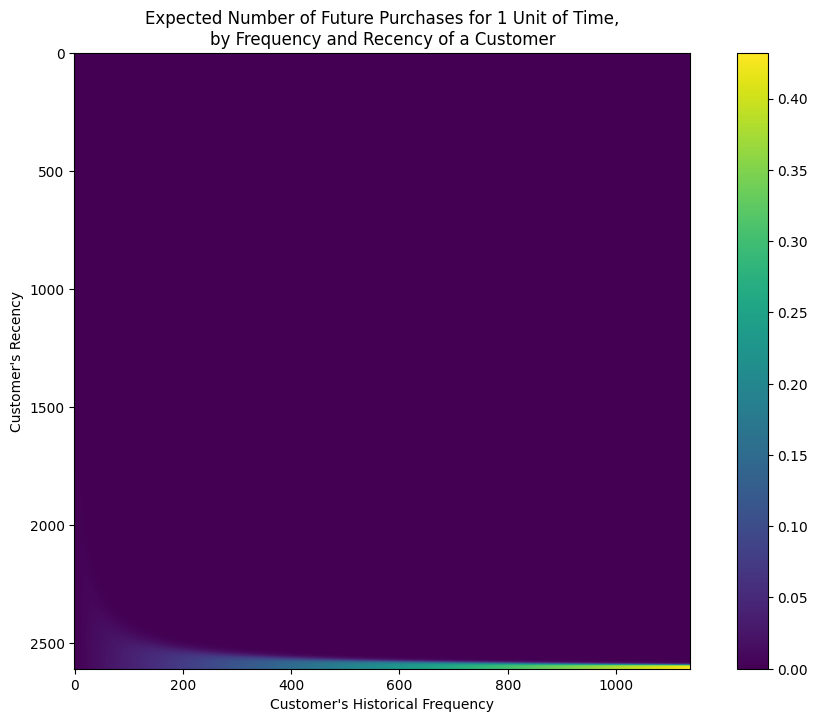

In [70]:
# Визуализация frequency/recency
fig = plt.figure(figsize=(12, 8))
plot_frequency_recency_matrix(mbgf)

c:\Codding\Customer-Churn-prediction\.venv\lib\site-packages\btyd\fitters\modified_beta_geo_fitter.py:213: RuntimeWarning: overflow encountered in power
  return np.atleast_1d(1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency)))


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

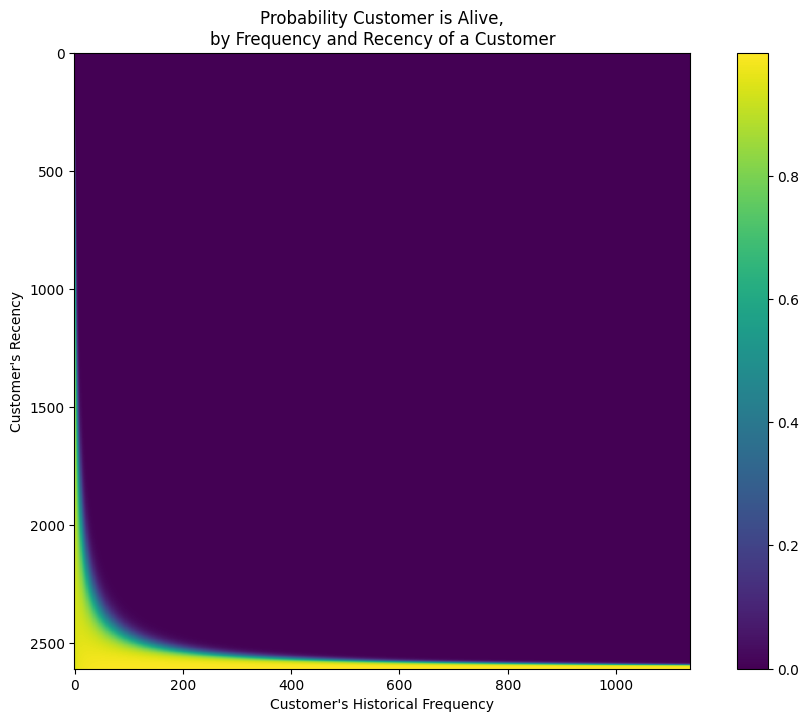

In [71]:
# Визуализация вероятности, что клиент жив:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(mbgf)

Посмотрим на предсказания модели: какое количество покупок клиент ожидаемо совершит в течение следующих 90 дней

In [10]:
days = 90

BGF

In [11]:
rfm_data_train["pred_num_trans_bgf"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    days, rfm_data_train["frequency"], rfm_data_train["recency"], rfm_data_train["T"]
)

In [12]:
rfm_data_test["pred_num_trans_bgf"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    days, rfm_data_test["frequency"], rfm_data_test["recency"], rfm_data_test["T"]
)

MBGF

In [13]:
rfm_data_train["pred_num_trans_mbgf"] = mbgf.conditional_expected_number_of_purchases_up_to_time(
    days, rfm_data_train["frequency"], rfm_data_train["recency"], rfm_data_train["T"]
)

In [14]:
rfm_data_test["pred_num_trans_mbgf"] = mbgf.conditional_expected_number_of_purchases_up_to_time(
    days, rfm_data_test["frequency"], rfm_data_test["recency"], rfm_data_test["T"]
)

Если ожидаемых покупок > 0.5, то клиент "живой"

In [33]:
rfm_data_train["pred_alive_bgf"] = rfm_data_train["pred_num_trans_bgf"] > 0.5
rfm_data_test["pred_alive_bgf"] = rfm_data_test["pred_num_trans_bgf"] > 0.5

In [34]:
rfm_data_train["pred_alive_mbgf"] = rfm_data_train["pred_num_trans_mbgf"] > 0.5
rfm_data_test["pred_alive_mbgf"] = rfm_data_test["pred_num_trans_mbgf"] > 0.5

100%|██████████| 1356307/1356307 [08:41<00:00, 2602.98it/s]


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

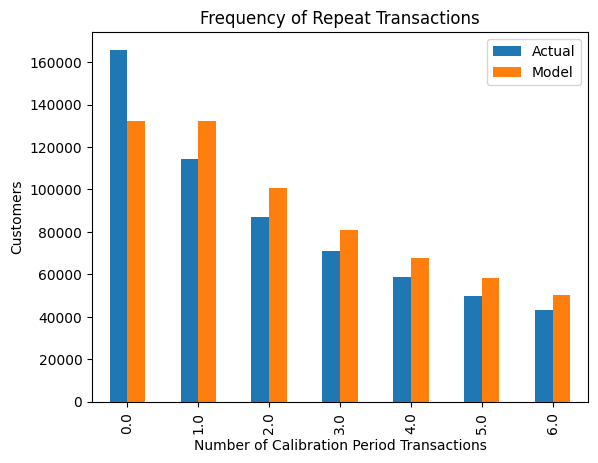

In [72]:
plot_period_transactions(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

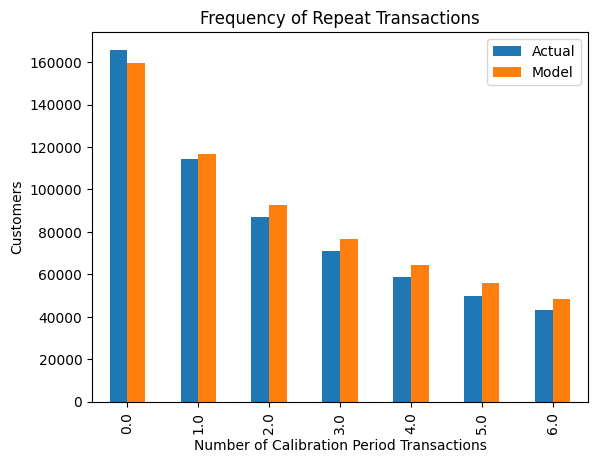

In [73]:
plot_period_transactions(mbgf)

In [ ]:
no_one_timers_customers_train = rfm_data_train[rfm_data_train['frequency']>0]
print("Количество не one-timer'ов на тренировочной выборке: ",len(no_one_timers_customers_train))

In [ ]:
no_one_timers_customers_test = rfm_data_test[rfm_data_test['frequency']>0]
print("Количество не one-timer'ов на тестовой выборке: ",len(no_one_timers_customers_test))

Рассчитаем среднюю сумму транзакции для живых клиентов в течение следующего месяца (time)

In [ ]:
ggf = GammaGammaFitter()
ggf.fit(no_one_timers_customers_train['frequency'],
        no_one_timers_customers_train['monetary_value'])
print(ggf)

BGF

In [74]:
rfm_data_train['CLV_bgf'] = ggf.customer_lifetime_value(
    bgf,
    rfm_data_train['frequency'],
    rfm_data_train['recency'],
    rfm_data_train['T'],
    rfm_data_train['monetary_value'],
    time=1,
)

NameError: name 'ggf' is not defined

In [ ]:
rfm_data_test['CLV_bgf'] = ggf.customer_lifetime_value(
    bgf,
    rfm_data_test['frequency'],
    rfm_data_test['recency'],
    rfm_data_test['T'],
    rfm_data_test['monetary_value'],
    time=1,
)

MBGF

In [ ]:
rfm_data_train['CLV_mbgf'] = ggf.customer_lifetime_value(
    mbgf,
    rfm_data_train['frequency'],
    rfm_data_train['recency'],
    rfm_data_train['T'],
    rfm_data_train['monetary_value'],
    time=1,
)

In [ ]:
rfm_data_test['CLV_mbgf'] = ggf.customer_lifetime_value(
    mbgf,
    rfm_data_test['frequency'],
    rfm_data_test['recency'],
    rfm_data_test['T'],
    rfm_data_test['monetary_value'],
    time=1,
)

In [ ]:
rfm_data_train.loc[~rfm_data_train['pred_alive_bgf'], 'CLV_bgf'] = None
rfm_data_test.loc[~rfm_data_test['pred_alive_bgf'], 'CLV_bgf'] = None

In [ ]:
rfm_data_train.loc[~rfm_data_train['pred_alive_mbgf'], 'CLV_mbgf'] = None
rfm_data_test.loc[~rfm_data_test['pred_alive_mbgf'], 'CLV_mbgf'] = None

Посмотрим количество активных и не активных клиентов

BGF

In [ ]:
rfm_data_train['pred_alive_bgf'].value_counts()

In [ ]:
rfm_data_test['pred_alive_bgf'].value_counts()

MBGF

In [ ]:
rfm_data_train['pred_alive_mbgf'].value_counts()

In [ ]:
rfm_data_test['pred_alive_mbgf'].value_counts()

Сравним с Baseline и посчитаем метрики

Baseline: Если клиент не совершал транзакции последние 90 дней, то считаем его неактивным

In [40]:
raw_data["rep_date"].max()

datetime.date(2023, 2, 23)

Последняя транзакция - 2023-02-23

In [49]:
raw_data["rep_date"] = pd.to_datetime(raw_data["rep_date"])

In [50]:
grouped_raw_df = raw_data.groupby('partner')['rep_date'].agg(['first', 'last']).reset_index()

In [51]:
grouped_raw_df['days_since_last'] = (pd.to_datetime('2023-02-23') - grouped_raw_df['last']).dt.days

In [52]:
grouped_raw_df['base_alive'] = grouped_raw_df['days_since_last'] <= 90

In [56]:
rfm_data_train = rfm_data_train.merge(grouped_raw_df[['partner', 'base_alive']], on='partner')

In [57]:
rfm_data_test = rfm_data_test.merge(grouped_raw_df[['partner', 'base_alive']], on='partner')

Посчитаем метрики для BGF и MBGF

In [59]:
def calc_score(target: Series, predicted: Series) -> None:
    recall = recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    precision = precision_score(target, predicted)
    roc_auc = roc_auc_score(target, predicted)
    acc = accuracy_score(target, predicted)
    gini_coeff = 2 * roc_auc - 1

    print(
        f"recall: {recall:.3f}\nf1: {f1:.3f}\nprecision: {precision:.3f}\nroc_auc: {roc_auc:.3f}\naccuracy: {acc:.3f}\nGini coeff: {gini_coeff:.3f}"
    )

Метрики для BGF на тренировочной и тестовой выборках

In [60]:
calc_score(rfm_data_train["base_alive"], rfm_data_train["pred_alive_bgf"])

recall: 0.943
f1: 0.914
precision: 0.888
roc_auc: 0.945
accuracy: 0.946
Gini coeff: 0.890


In [61]:
calc_score(rfm_data_test["base_alive"], rfm_data_test["pred_alive_bgf"])

recall: 0.942
f1: 0.913
precision: 0.886
roc_auc: 0.944
accuracy: 0.945
Gini coeff: 0.888


Метрики для MBGF на тренировочной и тестовой выборках

In [62]:
calc_score(rfm_data_train["base_alive"], rfm_data_train["pred_alive_mbgf"])

recall: 0.947
f1: 0.915
precision: 0.886
roc_auc: 0.946
accuracy: 0.946
Gini coeff: 0.893


In [63]:
calc_score(rfm_data_test["base_alive"], rfm_data_test["pred_alive_mbgf"])

recall: 0.946
f1: 0.914
precision: 0.884
roc_auc: 0.946
accuracy: 0.945
Gini coeff: 0.891
